# Human-in-the-loop

에이전트는 신뢰할 수 없으며 작업을 성공적으로 수행하기 위해 인간의 입력이 필요할 수 있습니다. 

마찬가지로, 일부 작업에 대해서는 모든 것이 의도한 대로 실행되고 있는지 확인하기 위해 실행 전에 **사람이 직접 개입하여 "승인"** 을 요구하고 싶을 수 있습니다.

LangGraph는 여러 가지 방법으로 `human-in-the-loop` 워크플로를 지원합니다. 

이번 튜토리얼의 시작은 LangGraph의 `interrupt_before` 기능을 사용하여 항상 도구 노드를 중단하도록 하겠습니다.

In [13]:
# API 키를 환경변수로 관리하기 위한 설정 파일
from dotenv import load_dotenv

# API 키 정보 로드
load_dotenv()

True

In [1]:
# LangSmith 추적을 설정합니다. https://smith.langchain.com
# !pip install -qU langchain-teddynote
from langchain_teddynote import logging

# 프로젝트 이름을 입력합니다.
logging.langsmith("CH17-LangGraph-Modules")

LangSmith 추적을 시작합니다.
[프로젝트명]
CH17-LangGraph-Modules


In [2]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.tools import GoogleNews


########## 1. 상태 정의 ##########
# 상태 정의
class State(TypedDict):
    # 메시지 목록 주석 추가
    messages: Annotated[list, add_messages]


########## 2. 도구 정의 및 바인딩 ##########
# 도구 초기화
# 키워드로 뉴스 검색하는 도구 생성
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# LLM 초기화
llm = ChatOpenAI(model="gpt-4o-mini")

# 도구와 LLM 결합
llm_with_tools = llm.bind_tools(tools)


########## 3. 노드 추가 ##########
# 챗봇 함수 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {"messages": [llm_with_tools.invoke(state["messages"])]}


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)


# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

########## 4. 엣지 추가 ##########

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# START > chatbot
graph_builder.add_edge(START, "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

########## 5. MemorySaver 추가 ##########

# 메모리 저장소 초기화
memory = MemorySaver()

/Users/minjeong/Library/Caches/pypoetry/virtualenvs/langchain-kr-szXyjQUn-py3.11/lib/python3.11/site-packages/pydantic/_internal/_config.py:373: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'validate_by_name'
* 'smart_union' has been removed
  warnings.warn(message, UserWarning)


이제 그래프를 컴파일하고, `tools` 노드 전에 `interrupt_before`를 지정하십시오.

In [3]:
########## 6. interrupt_before 추가 ##########

# 그래프 빌더 컴파일
graph = graph_builder.compile(checkpointer=memory)

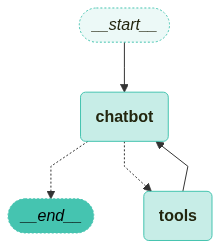

In [4]:
########## 7. 그래프 시각화 ##########
# 그래프 시각화
visualize_graph(graph)

In [5]:
from langchain_teddynote.messages import pretty_print_messages
from langchain_core.runnables import RunnableConfig

# 질문
question = "AI 관련 최신 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="values",
    interrupt_before=["tools"],  # tools 실행 전 interrupt(tools 노드 실행 전 중단)
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        # print(value)
        pretty_print_messages(value)

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.

[messages]

================================ Human Message =================================

AI 관련 최신 뉴스를 알려주세요.
================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_FHlbQ3R67EKnWnxzXMOyhABx)
 Call ID: call_FHlbQ3R67EKnWnxzXMOyhABx
  Args:
    query: AI


그래프 상태를 확인하여 제대로 작동했는지 확인해 봅시다.

In [6]:
# 그래프 상태 스냅샷 생성
snapshot = graph.get_state(config)

# 다음 스냅샷 상태
snapshot.next

('tools',)

(이전의 튜토리얼에서는) `__END__` 도달했기 때문에 `.next` 가 존재하지 않았습니다.

하지만, 지금은 `.next` 가 `tools` 로 지정되어 있습니다.

이제 그럼 도구 호출을 확인해 봅시다.

In [7]:
from langchain_teddynote.messages import display_message_tree

# 메시지 스냅샷에서 마지막 메시지 추출
existing_message = snapshot.values["messages"][-1]

# 메시지 트리 표시
display_message_tree(existing_message.tool_calls)

    index [0]
        name: "search_keyword"
        args: {"query": "AI"}
        id: "call_FHlbQ3R67EKnWnxzXMOyhABx"
        type: "tool_call"


다음으로는 이전에 종료된 지점 이후부터 **이어서 그래프를 진행** 해 보는 것입니다.

LangGraph 는 계속 그래프를 진행하는 것 쉽게 할 수 있습니다.

- 단지 입력에 `None`을 전달하면 됩니다.

In [8]:
# `None`는 현재 상태에 아무것도 추가하지 않음
events = graph.stream(None, config, stream_mode="values")

# 이벤트 반복 처리
for event in events:
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지의 예쁜 출력
        event["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_FHlbQ3R67EKnWnxzXMOyhABx)
 Call ID: call_FHlbQ3R67EKnWnxzXMOyhABx
  Args:
    query: AI
================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxQSHctcFpHRzJxOTgzZEduNW5rR2p3cUo1dVd4MmdCM0pDNWFGX0xXOXVkQzFLcEhTaGVwdHZ5Z2UtVXhiSmVFbTVDdmI5WDVhbnAzVEtZZUxLOTJzVmNpXzhuclhqbzBCNmZEdXBmTmlzS0ZCeWN3M2xEMU9ZVWg2RlJ30gGWAUFVX3lxTE90Z1VCdnFmRVZITHdRWWNnYUFhbTFoVFVkZThBVFdma3V2RGhMV1J0Q3g1YXEzaGlmaFlsbFZwYjVldGwxdGxfY0FGTElVTUVZTjlpbFI5aVVLQm5yOC1ONHlTS0VTSndNOXZpZjlDdkNiMUpwRGdsclZreHp4UGUxY04tU1c1anE4N0k5bzZZS2g3Y3BYQQ?oc=5", "content": "삼성전자 “명령하지 않아도 사용자 요구 파악… 똑똑한 AI 만들 것” - 조선비즈 - Chosunbiz"}, {"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTE5TZG9XU1VGUHBaRlJBRXNxWjhObkFlSE1JU3ZjanBYbnZGR2RzWHhSTjNpOXBGTUFXaElZZjdzS2cyQXBzN1VBZklna3lfQQ?oc=5", "content": "삼성,

이제, `interrupt`를 사용하여 챗봇에 인간이 개입할 수 있는 실행을 추가하여 필요할 때 인간의 감독과 개입을 가능하게 했습니다. 이는 추후에 시스템으로 구현할때, 잠재적인 UI를 제공할 수 있ㅅ브니다.

이미 **checkpointer**를 추가했기 때문에, 그래프는 **무기한** 일시 중지되고 언제든지 다시 시작할 수 있습니다.

아래는 `get_state_history` 메서드를 사용하여 상태 기록을 가져오는 방법입니다.

상태 기록을 통해 원하는 상태를 지정하여 **해당 지점에서 다시 시작** 할 수 있습니다.

In [9]:
to_replay = None

# 상태 기록 가져오기
for state in graph.get_state_history(config):
    # 메시지 수 및 다음 상태 출력
    print("메시지 수: ", len(state.values["messages"]), "다음 노드: ", state.next)
    print("-" * 80)
    # 특정 상태 선택 기준: 채팅 메시지 수
    if len(state.values["messages"]) == 3:
        to_replay = state

메시지 수:  4 다음 노드:  ()
--------------------------------------------------------------------------------
메시지 수:  3 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  2 다음 노드:  ('tools',)
--------------------------------------------------------------------------------
메시지 수:  1 다음 노드:  ('chatbot',)
--------------------------------------------------------------------------------
메시지 수:  0 다음 노드:  ('__start__',)
--------------------------------------------------------------------------------


그래프의 모든 단계에 대해 체크포인트가 저장된다는 점에 **주목** 할 필요가 있습니다.

원하는 지점은 `to_replay` 변수에 저장합니다. 이를 활용하여 다시 시작할 수 있는 지점을 지정할 수 있습니다.

In [10]:
# 다음 항목의 다음 요소 출력
print(to_replay.next)

# 다음 항목의 설정 정보 출력
print(to_replay.config)

('chatbot',)
{'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1f05febf-8b48-6c38-8002-0868d2ca234d'}}


`to_replay.config` 에 `checkpoint_id` 가 포함되어 있습니다.

In [11]:
to_replay.config

{'configurable': {'thread_id': '1',
  'checkpoint_ns': '',
  'checkpoint_id': '1f05febf-8b48-6c38-8002-0868d2ca234d'}}

이 `checkpoint_id` 값을 제공하면 LangGraph의 체크포인터가 그 시점의 상태를 **로드** 할 수 있습니다.

- 단, 이때는 입력값을 `None`으로 전달해야 합니다.

아래의 예제를 통해 확인해 봅시다.

In [12]:
# `to_replay.config`는 `checkpoint_id`는 체크포인터에 저장된 상태에 해당
for event in graph.stream(None, to_replay.config, stream_mode="values"):
    # 메시지가 이벤트에 포함된 경우
    if "messages" in event:
        # 마지막 메시지 출력
        event["messages"][-1].pretty_print()

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMiggFBVV95cUxQSHctcFpHRzJxOTgzZEduNW5rR2p3cUo1dVd4MmdCM0pDNWFGX0xXOXVkQzFLcEhTaGVwdHZ5Z2UtVXhiSmVFbTVDdmI5WDVhbnAzVEtZZUxLOTJzVmNpXzhuclhqbzBCNmZEdXBmTmlzS0ZCeWN3M2xEMU9ZVWg2RlJ30gGWAUFVX3lxTE90Z1VCdnFmRVZITHdRWWNnYUFhbTFoVFVkZThBVFdma3V2RGhMV1J0Q3g1YXEzaGlmaFlsbFZwYjVldGwxdGxfY0FGTElVTUVZTjlpbFI5aVVLQm5yOC1ONHlTS0VTSndNOXZpZjlDdkNiMUpwRGdsclZreHp4UGUxY04tU1c1anE4N0k5bzZZS2g3Y3BYQQ?oc=5", "content": "삼성전자 “명령하지 않아도 사용자 요구 파악… 똑똑한 AI 만들 것” - 조선비즈 - Chosunbiz"}, {"url": "https://news.google.com/rss/articles/CBMiTkFVX3lxTE5TZG9XU1VGUHBaRlJBRXNxWjhObkFlSE1JU3ZjanBYbnZGR2RzWHhSTjNpOXBGTUFXaElZZjdzS2cyQXBzN1VBZklna3lfQQ?oc=5", "content": "삼성, 멀티모달 AI로 갤럭시 생태계 확장 - 전자신문"}, {"url": "https://news.google.com/rss/articles/CBMiVkFVX3lxTE5vWjhFU3FVRnU0blZubnY1U0d1eTBXMThyV25GbmlnSDdnSkQxeWtQSEV4WDRvc01scm96R2dYQnFFenBvTzlNNFlUYmY1TVF3RVFWVXF30gFXQVV